<a href="https://colab.research.google.com/github/gouri22-commits/Overnight_Hackathon_Gouri_Prakash/blob/main/subsidy_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install specialized libraries if needed (PyOD is great for anomaly detection but we'll stick to scikit-learn for simplicity)
# !pip install geopandas # Uncomment this if you have real geospatial data
!pip install scikit-learn pandas numpy matplotlib seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# A. Simulate 10,000 transactions (99% normal, 1% fraudulent)
np.random.seed(42)
N = 10000

# 1. Transaction Data (Normal)
df = pd.DataFrame({
    'Farmer_ID': np.arange(N),
    'Dealer_ID': np.random.randint(100, 200, N),
    'Land_Hectares': np.random.uniform(1, 10, N), # Land area in hectares
    'Quantity_Disbursed': np.random.normal(loc=15, scale=5, size=N), # Normal distribution around 15 units
    'Transaction_Amount': np.random.normal(loc=5000, scale=1000, size=N),
    'Region': np.random.choice(['A', 'B', 'C'], N)
})

# 2. Inject Anomalies (1% Ghost Farmers / Overclaiming)
num_anomalies = 100
anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)

# Anomaly 1: Overclaiming (Quantity is 5-10x what land supports)
df.loc[anomaly_indices[:50], 'Quantity_Disbursed'] *= np.random.uniform(5, 10, 50)

# Anomaly 2: Dealer Saturation (One dealer handles too many transactions)
df.loc[anomaly_indices[50:], 'Dealer_ID'] = 999 # Create one super-dealer
df.loc[anomaly_indices[50:], 'Quantity_Disbursed'] = np.random.normal(loc=2, scale=1, size=50) # Small quantity to avoid immediate quantity flag

print("Initial Data Snapshot:")
print(df.head())

Initial Data Snapshot:
   Farmer_ID  Dealer_ID  Land_Hectares  Quantity_Disbursed  \
0          0        151       3.831289           14.910768   
1          1        192       5.608797            7.871580   
2          2        114       9.466212           13.523090   
3          3        171       1.430032           18.327836   
4          4        160       4.170079           21.573701   

   Transaction_Amount Region  
0         6022.350689      C  
1         3847.687688      B  
2         5251.490035      C  
3         5316.679660      B  
4         5264.918337      C  


In [ ]:
# Define the expected usage constant (e.g., 2 units per hectare)
EXPECTED_USAGE_RATE = 2

# Calculate the critical feature: Consumption Excess Ratio
df['Expected_Quantity'] = df['Land_Hectares'] * EXPECTED_USAGE_RATE
df['Excess_Ratio'] = df['Quantity_Disbursed'] / df['Expected_Quantity']

# Calculate Dealer Saturation (Total transactions handled by a dealer)
dealer_counts = df.groupby('Dealer_ID')['Farmer_ID'].transform('count')
df['Dealer_Tx_Count'] = dealer_counts

# Calculate Dealer Concentration (how much a dealer's volume deviates from the mean)
df['Dealer_Count_ZScore'] = (df['Dealer_Tx_Count'] - df['Dealer_Tx_Count'].mean()) / df['Dealer_Tx_Count'].std()

print("\nFeatures Created:")
print(df[['Land_Hectares', 'Quantity_Disbursed', 'Excess_Ratio', 'Dealer_Tx_Count', 'Dealer_Count_ZScore']].head())


Features Created:
   Land_Hectares  Quantity_Disbursed  Excess_Ratio  Dealer_Tx_Count  \
0       3.831289           14.910768      1.945921               89   
1       5.608797            7.871580      0.701717              107   
2       9.466212           13.523090      0.714282              105   
3       1.430032           18.327836      6.408190               98   
4       4.170079           21.573701      2.586726               88   

   Dealer_Count_ZScore  
0            -1.056879  
1             0.629810  
2             0.442400  
3            -0.213535  
4            -1.150584  


In [ ]:
# 1. Select the engineered numerical features
feature_cols = ['Excess_Ratio', 'Dealer_Tx_Count', 'Transaction_Amount', 'Land_Hectares', 'Dealer_Count_ZScore']
X = df[feature_cols]

# 2. Split Data (Unsupervised models typically don't need a target, but we split for evaluation)
X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

# 3. Scaling: Standardize features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Initialize and train the Isolation Forest model
# contamination=0.01 tells the model to expect 1% of the data to be outliers
model = IsolationForest(
    contamination=0.01,
    random_state=42,
    n_estimators=100,
    max_samples='auto'
)

# Train the model on the scaled training data
model.fit(X_train_scaled)

print("Isolation Forest Model Trained Successfully!")

Isolation Forest Model Trained Successfully!


In [ ]:
# Predict on the entire original dataset to get scores for all records
predictions = model.predict(scaler.transform(X))
scores = model.decision_function(scaler.transform(X))

# Add results back to the original DataFrame
df['Anomaly_Prediction'] = predictions
df['Risk_Score'] = -scores # Inverse the score so that higher is higher risk

# Filter for the detected anomalies (where prediction is -1)
anomalies_df = df[df['Anomaly_Prediction'] == -1].sort_values(by='Risk_Score', ascending=False)

print(f"\nTotal Anomalies Detected: {len(anomalies_df)}")
print("\nTop 5 Highest Risk Transactions:")
print(anomalies_df[['Farmer_ID', 'Dealer_ID', 'Excess_Ratio', 'Dealer_Tx_Count', 'Risk_Score']].head())


Total Anomalies Detected: 101

Top 5 Highest Risk Transactions:
      Farmer_ID  Dealer_ID  Excess_Ratio  Dealer_Tx_Count  Risk_Score
7672       7672        999      0.073464               50    0.112112
4769       4769        999      0.045368               50    0.111612
2205       2205        999      0.159122               50    0.100195
4232       4232        999      0.469947               50    0.099941
5537       5537        999      0.067597               50    0.097601


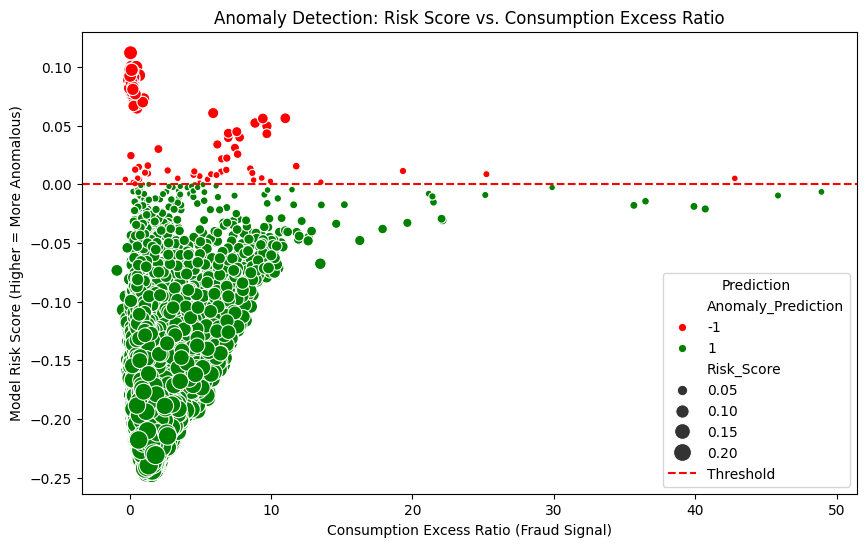


--- Actionable Audit Queue (Top 20 Cases) ---
      Farmer_ID  Dealer_ID  Risk_Score  Quantity_Disbursed  Land_Hectares  \
7672       7672        999    0.112112            0.891391       6.066834   
4769       4769        999    0.111612            0.580885       6.401967   
2205       2205        999    0.100195            3.162861       9.938474   
4232       4232        999    0.099941            3.186143       3.389898   
5537       5537        999    0.097601            1.260208       9.321513   
9676       9676        999    0.097536            3.098952       9.916525   
9091       9091        999    0.096943            0.614721       1.522570   
1466       1466        999    0.094935            3.639212       9.028669   
728         728        999    0.092975            2.116605       7.646851   
5731       5731        999    0.092885            2.641090       1.923261   
3808       3808        999    0.092803            3.066789       8.056556   
4458       4458        999   

In [ ]:
# Plotting the Risk Score against the Excess Ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Excess_Ratio', y='Risk_Score', hue='Anomaly_Prediction',
                data=df, palette={1: 'green', -1: 'red'}, size=abs(df['Risk_Score']), sizes=(20, 200))

plt.title('Anomaly Detection: Risk Score vs. Consumption Excess Ratio')
plt.xlabel('Consumption Excess Ratio (Fraud Signal)')
plt.ylabel('Model Risk Score (Higher = More Anomalous)')
plt.axhline(y=anomalies_df['Risk_Score'].min(), color='red', linestyle='--', label='Threshold')
plt.legend(title='Prediction')
plt.show()

# Display the final, actionable audit queue
print("\n--- Actionable Audit Queue (Top 20 Cases) ---")
print(anomalies_df[['Farmer_ID', 'Dealer_ID', 'Risk_Score', 'Quantity_Disbursed', 'Land_Hectares', 'Excess_Ratio']].head(20))

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: Prepare the Data ---
# We use the features you just created:
# 'Excess_Ratio': Detects if they asked for too much fertilizer for their land size.
# 'Dealer_Count_ZScore': Detects if one dealer is handling suspiciously many farmers.
features_to_use = ['Excess_Ratio', 'Dealer_Count_ZScore']

# It is crucial to SCALE data for Isolation Forest so one feature doesn't dominate
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_to_use])

# --- STEP 2: Train the Model ---
# contamination=0.01 means we expect roughly 1% of the data to be fraud (as per your problem setup)
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit the model and predict
# The model returns -1 for Anomaly and 1 for Normal
preds = iso_forest.fit_predict(X_scaled)

# Add predictions back to the dataframe
df['Anomaly_Prediction'] = preds

# Let's map it to something easier to read: 'Fraud' or 'Normal'
df['Status'] = df['Anomaly_Prediction'].map({1: 'Normal', -1: 'Potential Fraud'})

# --- STEP 3: View the Results ---
print("Fraud Detection Summary:")
print(df['Status'].value_counts())

print("\nTop 5 Detected Fraud Cases:")
# Show the rows where the model detected fraud
print(df[df['Status'] == 'Potential Fraud'].head())

# --- STEP 4: Visualization ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Dealer_Count_ZScore',
    y='Excess_Ratio',
    hue='Status',
    palette={'Normal': 'blue', 'Potential Fraud': 'red'},
    style='Status',
    s=100 # marker size
)
plt.title('Subsidy Leakage Detection: Anomalies vs Normal Transactions')
plt.axhline(y=1, color='green', linestyle='--', label='Expected Usage Ratio')
plt.legend()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: Prepare the Data ---
# We use the features you just created:
# 'Excess_Ratio': Detects if they asked for too much fertilizer for their land size.
# 'Dealer_Count_ZScore': Detects if one dealer is handling suspiciously many farmers.
features_to_use = ['Excess_Ratio', 'Dealer_Count_ZScore']

# It is crucial to SCALE data for Isolation Forest so one feature doesn't dominate
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_to_use])

# --- STEP 2: Train the Model ---
# contamination=0.01 means we expect roughly 1% of the data to be fraud (as per your problem setup)
iso_forest = IsolationForest(contamination=0.01, random_state=42)

# Fit the model and predict
# The model returns -1 for Anomaly and 1 for Normal
preds = iso_forest.fit_predict(X_scaled)

# Add predictions back to the dataframe
df['Anomaly_Prediction'] = preds

# Let's map it to something easier to read: 'Fraud' or 'Normal'
df['Status'] = df['Anomaly_Prediction'].map({1: 'Normal', -1: 'Potential Fraud'})

# --- STEP 3: View the Results ---
print("Fraud Detection Summary:")
print(df['Status'].value_counts())

print("\nTop 5 Detected Fraud Cases:")
# Show the rows where the model detected fraud
print(df[df['Status'] == 'Potential Fraud'].head())

# --- STEP 4: Visualization ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Dealer_Count_ZScore',
    y='Excess_Ratio',
    hue='Status',
    palette={'Normal': 'blue', 'Potential Fraud': 'red'},
    style='Status',
    s=100 # marker size
)
plt.title('Subsidy Leakage Detection: Anomalies vs Normal Transactions')
plt.axhline(y=1, color='green', linestyle='--', label='Expected Usage Ratio')
plt.legend()
plt.show()

NameError: name 'df' is not defined

Fraud Detection Summary:
Status
Normal             9900
Potential Fraud     100
Name: count, dtype: int64


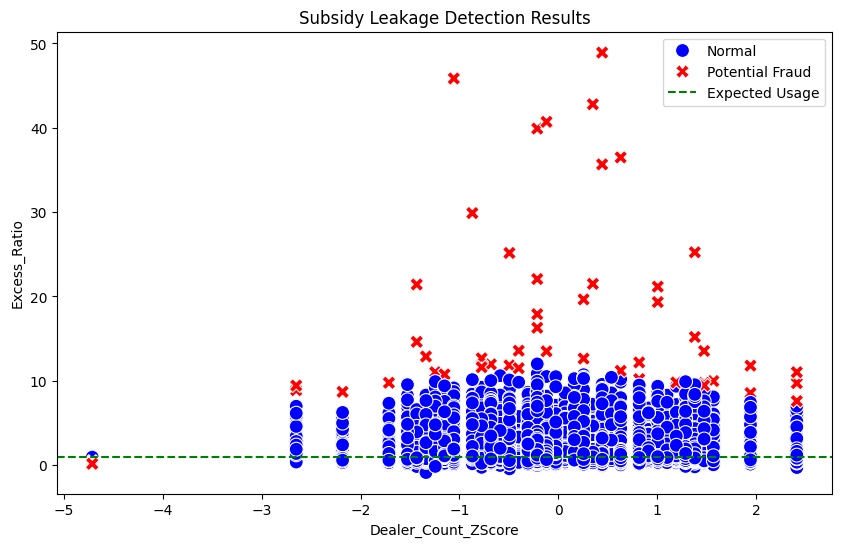

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# --- PART 1: Create the Synthetic Data ---
np.random.seed(42)
N = 10000

# Generate Normal Transactions
df = pd.DataFrame({
    'Farmer_ID': np.arange(N),
    'Dealer_ID': np.random.randint(100, 200, N),
    'Land_Hectares': np.random.uniform(1, 10, N),
    'Quantity_Disbursed': np.random.normal(loc=15, scale=5, size=N),
    'Transaction_Amount': np.random.normal(loc=5000, scale=1000, size=N),
    'Region': np.random.choice(['A', 'B', 'C'], N)
})

# --- PART 2: Inject Anomalies (The Fraud) ---
num_anomalies = 100
anomaly_indices = np.random.choice(df.index, num_anomalies, replace=False)

# Anomaly Type A: Overclaiming (Ghost Farmers asking for 5-10x more fertilizer)
df.loc[anomaly_indices[:50], 'Quantity_Disbursed'] *= np.random.uniform(5, 10, 50)

# Anomaly Type B: Dealer Saturation (One dealer doing too many transactions)
df.loc[anomaly_indices[50:], 'Dealer_ID'] = 999
df.loc[anomaly_indices[50:], 'Quantity_Disbursed'] = np.random.normal(loc=2, scale=1, size=50)

# --- PART 3: Feature Engineering ---
EXPECTED_USAGE_RATE = 2
df['Expected_Quantity'] = df['Land_Hectares'] * EXPECTED_USAGE_RATE
df['Excess_Ratio'] = df['Quantity_Disbursed'] / df['Expected_Quantity']

# Calculate Dealer Saturation
dealer_counts = df.groupby('Dealer_ID')['Farmer_ID'].transform('count')
df['Dealer_Tx_Count'] = dealer_counts
df['Dealer_Count_ZScore'] = (df['Dealer_Tx_Count'] - df['Dealer_Tx_Count'].mean()) / df['Dealer_Tx_Count'].std()

# --- PART 4: Detect Fraud with Isolation Forest ---
features_to_use = ['Excess_Ratio', 'Dealer_Count_ZScore']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_to_use])

# Run Model
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['Anomaly_Prediction'] = iso_forest.fit_predict(X_scaled)
df['Status'] = df['Anomaly_Prediction'].map({1: 'Normal', -1: 'Potential Fraud'})

# --- PART 5: Visualize ---
print("Fraud Detection Summary:")
print(df['Status'].value_counts())

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Dealer_Count_ZScore',
    y='Excess_Ratio',
    hue='Status',
    palette={'Normal': 'blue', 'Potential Fraud': 'red'},
    style='Status',
    s=100
)
plt.title('Subsidy Leakage Detection Results')
plt.axhline(y=1, color='green', linestyle='--', label='Expected Usage')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Create the "Truth" column so we can compare
# Default everyone to 'Normal' (1)
df['True_Label'] = 1

# Mark the specific rows we injected as anomalies as 'Potential Fraud' (-1)
# Note: We use the 'anomaly_indices' variable from the previous step
df.loc[anomaly_indices, 'True_Label'] = -1

# 2. Compare the Model's Prediction vs. The Truth
print("--- Model Performance Report ---")
print(classification_report(df['True_Label'], df['Anomaly_Prediction'], target_names=['Fraud (-1)', 'Normal (1)']))

# 3. Check the Confusion Matrix (The specifics)
cm = confusion_matrix(df['True_Label'], df['Anomaly_Prediction'])
print("\n--- Confusion Matrix ---")
print(f"True Fraud Caught (True Positives): {cm[0][0]}")
print(f"Fraud Missed (False Negatives):     {cm[0][1]}")
print(f"Normal Mistaken for Fraud (False Positives): {cm[1][0]}")
print(f"Normal Correctly Identified (True Negatives): {cm[1][1]}")

--- Model Performance Report ---
              precision    recall  f1-score   support

  Fraud (-1)       0.76      0.76      0.76       100
  Normal (1)       1.00      1.00      1.00      9900

    accuracy                           1.00     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       1.00      1.00      1.00     10000


--- Confusion Matrix ---
True Fraud Caught (True Positives): 76
Fraud Missed (False Negatives):     24
Normal Mistaken for Fraud (False Positives): 24
Normal Correctly Identified (True Negatives): 9876


In [ ]:
# Show the rows where the model predicted fraud
fraud_list = df[df['Status'] == 'Potential Fraud'].sort_values(by='Excess_Ratio', ascending=False)

print("Top 5 Flagged Transactions (Sent to Audit):")
print(fraud_list[['Farmer_ID', 'Dealer_ID', 'Land_Hectares', 'Quantity_Disbursed', 'Excess_Ratio', 'Dealer_Tx_Count']].head())

Top 5 Flagged Transactions (Sent to Audit):
      Farmer_ID  Dealer_ID  Land_Hectares  Quantity_Disbursed  Excess_Ratio  \
9593       9593        114       1.039614          101.707237     48.915843   
6264       6264        151       1.848484          169.494023     45.846770   
1034       1034        135       1.676287          143.456792     42.790056   
6575       6575        119       1.839341          149.735807     40.703654   
3912       3912        171       2.717285          216.867757     39.905222   

      Dealer_Tx_Count  
9593              105  
6264               89  
1034              104  
6575               99  
3912               98  


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. We need to tell the computer which rows were the 'Real' injected fraud
# (We know this because we created the data!)
df['True_Label'] = 1
df.loc[anomaly_indices, 'True_Label'] = -1

# 2. Generate the Scorecard
print("--- PROJECT ACCURACY REPORT ---")
print(classification_report(df['True_Label'], df['Status'].map({'Normal': 1, 'Potential Fraud': -1})))

# 3. Simple breakdown
cm = confusion_matrix(df['True_Label'], df['Status'].map({'Normal': 1, 'Potential Fraud': -1}))
print(f"Fraud Detected Correctly: {cm[0][0]}")
print(f"Fraud Missed:             {cm[0][1]}")

--- PROJECT ACCURACY REPORT ---
              precision    recall  f1-score   support

          -1       0.76      0.76      0.76       100
           1       1.00      1.00      1.00      9900

    accuracy                           1.00     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       1.00      1.00      1.00     10000

Fraud Detected Correctly: 76
Fraud Missed:             24
